In [1]:
if 1:
  !nvidia-smi

  !pip install -Uqq fastbook
  import fastbook
  fastbook.setup_book

  from google.colab import drive
  #drive.mount('/content/drive')

Sat May  8 16:33:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from fastai.tabular.all import *

In [3]:
creds = '{"username":"sandermann","key":"34a608a514ebc417693865ab9a19512b"}'

In [4]:
#shutil.rmtree(cred_path.parent)

In [5]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
  cred_path.parent.mkdir(exist_ok=True)
  cred_path.write_text(creds)
  cred_path.chmod(0o600)

In [6]:
from kaggle import *

In [7]:
#!kaggle competitions download -c tabular-playground-series-apr-2021

In [8]:
#file_extract(path/'tabular-playground-series-apr-2021.zip')

In [9]:
path = URLs.path('playground_april')
path

Path('/root/.fastai/archive/playground_april')

In [10]:
#shutil.rmtree(path)

In [11]:
if not path.exists():
  path.mkdir(parents=True)
  api.competition_download_cli('tabular-playground-series-apr-2021', path=path)
  file_extract(path/'tabular-playground-series-apr-2021.zip')

path.ls()

(#4) [Path('/root/.fastai/archive/playground_april/train.csv'),Path('/root/.fastai/archive/playground_april/tabular-playground-series-apr-2021.zip'),Path('/root/.fastai/archive/playground_april/test.csv'),Path('/root/.fastai/archive/playground_april/sample_submission.csv')]

In [12]:
df = pd.read_csv(path/'train.csv', low_memory=False)

In [13]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB


In [15]:
df.shape

(100000, 12)

In [16]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [17]:
df.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)

In [18]:
dep_var = 'Survived'

In [19]:
procs = [Categorify, FillMissing, Normalize]

In [20]:
cont, cat = cont_cat_split(df, dep_var=dep_var)

In [21]:
cont, cat

(['Age', 'Fare'], ['Pclass', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Embarked'])

In [22]:
idx = np.random.permutation(range(len(df))).squeeze()

In [23]:
idx.shape

(100000,)

In [24]:
to = TabularPandas(df, procs, cat, cont, dep_var, splits=RandomSplitter(seed=42)(range_of(df)))

In [25]:
len(to.train), len(to.valid)

(80000, 20000)

In [26]:
to.show(3)

,Pclass,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare,Survived
1509,3,female,1,0,9311,S,False,False,67.0,29.680000,0
83391,3,male,1,2,S.O.C. 23844,S,False,False,30.0,27.450001,0
62311,2,female,1,1,151455,C,False,False,45.0,28.690001,0


In [27]:
to.xs[:3]

,Pclass,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
1509,3,1,2,1,51792,3,1,1,1.591081,-0.204969
83391,3,2,2,3,68733,3,1,1,-0.464173,-0.237166
62311,2,1,2,2,4381,1,1,1,0.369038,-0.219263


In [42]:
dls = to.dataloaders(64)

In [43]:
y = to.train.y
y.min(), y.max()

(0, 1)

In [44]:
learn = tabular_learner(dls, loss_func=CrossEntropyLossFlat(), n_out=2, metrics=accuracy)

SuggestedLRs(lr_min=0.007585775852203369, lr_steep=8.128305353238829e-07)

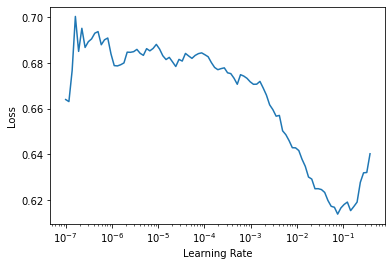

In [45]:
learn.lr_find(end_lr=1)

In [46]:
learn.fit_one_cycle(1) # acc: 0.76125

epoch,train_loss,valid_loss,accuracy,time
0,0.487464,0.493596,0.767400,00:36


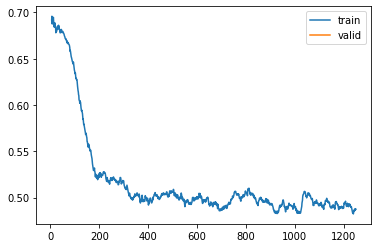

In [47]:
learn.recorder.plot_loss()

In [48]:
learn.summary()

TabularModel (Input shape: 64 x torch.Size([64, 2]))
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 3              
Embedding                                 12         True      
Embedding                                 9          True      
____________________________________________________________________________
                     64 x 5              
Embedding                                 40         True      
Embedding                                 45         True      
____________________________________________________________________________
                     64 x 600            
Embedding                                 45199200   True      
____________________________________________________________________________
                     64 x 3              
Embedding                                 12         True      
Embedding                                 9          True      
Embedding                           

In [49]:
learn.show_results()

,Pclass,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare,Survived,Survived_pred
0,3.0,2.0,1.0,1.0,54276.0,3.0,1.0,1.0,-0.964100,-0.473081,0.0,0.0
1,1.0,2.0,1.0,1.0,71732.0,3.0,1.0,1.0,0.202396,0.920033,0.0,0.0
2,3.0,1.0,1.0,1.0,0.0,3.0,1.0,1.0,-0.741911,-0.512497,1.0,1.0
3,2.0,2.0,1.0,1.0,13088.0,3.0,1.0,1.0,-0.297531,-0.274416,0.0,0.0
4,1.0,2.0,1.0,1.0,52404.0,3.0,1.0,1.0,0.980059,2.532892,0.0,0.0
5,1.0,1.0,1.0,1.0,5199.0,3.0,1.0,1.0,0.369038,-0.294629,1.0,1.0
6,2.0,1.0,2.0,2.0,37438.0,3.0,1.0,1.0,-1.686217,-0.134801,1.0,1.0
7,1.0,2.0,1.0,1.0,11458.0,3.0,1.0,1.0,-0.686363,-0.429623,0.0,0.0
8,3.0,2.0,1.0,1.0,46632.0,3.0,1.0,1.0,0.480133,-0.466007,0.0,0.0


In [50]:
learn.predict(df.iloc[0])

TypeError: ignored

In [ ]:
learn.get_preds()

In [52]:
dft = pd.read_csv(path/'test.csv', low_memory=False)

In [53]:
dft.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)

In [54]:
dl_test = learn.dls.test_dl(dft)

In [57]:
probs, _ = learn.get_preds(dl=dl_test)

In [58]:
preds = torch.argmax(probs, dim=1)

In [59]:
preds.shape

torch.Size([100000])

In [62]:
preds[:5]

tensor([0, 0, 1, 0, 1])

In [64]:
df_test = pd.read_csv(path/'test.csv', low_memory=False)

In [65]:
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': preds})

In [66]:
output.head()

,PassengerId,Survived
0,100000,0
1,100001,0
2,100002,1
3,100003,0
4,100004,1


In [67]:
output.to_csv('fastai_R00.csv', index=False)

In [70]:
api.competition_submit('/content/fastai_R00.csv', message='first try', competition='tabular-playground-series-apr-2021')

100%|██████████| 879k/879k [00:00<00:00, 2.37MB/s]


Successfully submitted to Tabular Playground Series - Apr 2021